<a href="https://colab.research.google.com/github/janwaelty/Master-Thesis/blob/main/visual_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Deep Learning for Art Market Valuation**

**This script provides the code for the multi-modal neural network model**


# 1. Module import

In [ ]:

import zipfile
import os
import shutil
from google.colab import drive
from torchvision.models import resnet50, ResNet50_Weights
import timm
import itertools
import random

# Mount Google Drive
drive.mount('/content/drive')
# Define source and destination paths
source_path = "/content/drive/My Drive/Colab Notebooks/visual_model.ipynb"
destination_path = "/content/drive/My Drive/visual_model.ipynb"

# Check if the source file exists before moving
if os.path.exists(source_path):
  # Move the file
  shutil.move(source_path, destination_path)
  print(f"Notebook moved to: {destination_path}")


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import linregress
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets, transforms

!cp /content/drive/My\ Drive/data_preprocess.py /content/

from data_preprocess import (
    data_split as data_split,
    fit_visualization as fit_visualization,
    repeated_to_single_transactions as repeated_to_single_transactions,
    one_hot as one_hot,
    data_filter as data_filter,
    load_image_data as load_image_data,
    check_image_existence as check_image_existence,
    filter_data_for_missing_images as filter_data_for_missing_images,
    resnet_transform as resnet_transform,
    vit_transform as vit_transform,
)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2. Visual model and training function

In [ ]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

class MixedTransactionDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, base_dir , transform=resnet_transform()):
         #image path and transform
        self.image_paths = [os.path.join(base_dir, path.lstrip('/')) for path in X['image_url'].dropna()]
        self.transform = transform
        # Ensure that all values are numeric and convert to numpy arrays of correct dtype
        self.X = X.drop(columns=['image_url']).reset_index(drop=True).values.astype('float32')
        self.y = y.reset_index(drop=True).values.astype('float32')

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):

        image = Image.open(self.image_paths[idx])
        if self.transform:
            image = self.transform(image)
        x = self.X[idx]
        y = self.y[idx]
        return torch.tensor(x, dtype=torch.float32), image, torch.tensor(y, dtype=torch.float32)


def create_dataloaders(X_train, X_test, y_train, y_test, transform=resnet_transform(), base_dir="/content/data", batch_size=128):
    train_dataset = MixedTransactionDataset(X_train, y_train, base_dir, transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size,
                              shuffle=True, num_workers=8, pin_memory=True)
    test_dataset = MixedTransactionDataset(X_test, y_test, base_dir, transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size,
                             shuffle=True, num_workers=8, pin_memory=True)
    return train_loader, test_loader

class FeatureProjection(nn.Module):
    def __init__(self, in_features, output_dim=100):
        super(FeatureProjection, self).__init__()
        self.fc = nn.Linear(in_features, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.relu(self.fc(x))

class CombinedModel(nn.Module):
    def __init__(self, in_features, projection_output_dim=100, image_output_dim=10,
                 model_type='resnet', fine_tune=True):
        super(CombinedModel, self).__init__()
        self.model_type = model_type
        self.feature_projection = FeatureProjection(in_features, projection_output_dim)
        self.layernorm = nn.LayerNorm(projection_output_dim + image_output_dim)
        self.fc1 = nn.Linear(projection_output_dim + image_output_dim, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.fc4 = nn.Linear(32, 1)
        self.dropout = nn.Dropout(0.3)
        self.relu = nn.ReLU()

        # Image branch (replace last layer output dimension)
        if model_type == 'resnet':
            image_model = resnet50(weights=ResNet50_Weights.DEFAULT)
            in_img_features = image_model.fc.in_features
            image_model.fc = nn.Linear(in_img_features, image_output_dim)
        elif model_type == 'vit':
            image_model = timm.create_model('vit_small_patch16_224', pretrained=True)
            in_img_features = image_model.head.in_features
            image_model.head = nn.Linear(in_img_features, image_output_dim)
        self.image_model = image_model

        # only fine tune last layers if required
        if not fine_tune:
            for param in image_model.parameters():
                param.requires_grad = False
            for name, param in image_model.named_parameters():
                if 'head' in name or 'fc'  in name:
                    param.requires_grad = True
        self.image_model = image_model


    def forward(self,x, image):
        x = self.feature_projection(x)
        # get image features
        img_feature = self.image_model(image)
        combined = torch.cat((x, img_feature), dim=1)
        combined = self.layernorm(combined)
        combined = self.relu(self.bn1(self.fc1(combined)))
        combined = self.dropout(combined)
        combined= self.relu(self.bn2(self.fc2(combined)))
        combined = self.relu(self.bn3(self.fc3(combined)))
        combined = self.fc4(combined)
        return combined

def train(network, trainloader, testloader, epochs=100, eta=0.0001):
    optimizer = torch.optim.Adam(network.parameters(), lr=eta, weight_decay=1e-4)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    network = network.to(device, non_blocking=True)
    loss = torch.nn.MSELoss()
    val_loss = []

    for epoch in range(epochs):
        # Initialize total loss for train and test data
        J_train = 0
        total_train_samples = 0  # Counter for number of train samples

        # Train the network on training data
        for x, image, t in trainloader:
          network.train()
          optimizer.zero_grad()
          x = x.to(device, non_blocking=True)
          image = image.to(device, non_blocking=True)
          t = t.to(device, non_blocking=True).view(-1, 1)
          prediction = network(x, image)
          J = loss(prediction, t)
          J_train += J.item() * x.size(0)
          total_train_samples += x.size(0)
          J.backward()
          optimizer.step()

        # Compute average train loss
        avg_train_loss = J_train / total_train_samples

        # Test on validation data
        J_test = 0

        total_test_samples = 0  # Counter for number of test samples
        with torch.no_grad():
            network.eval()
            for x, image, t in testloader:
                x = x.to(device, non_blocking=True)
                image = image.to(device, non_blocking=True)
                t = t.to(device, non_blocking=True).view(-1, 1)
                prediction = network(x, image)
                J = loss(prediction, t)
                J_test += J.item() * x.size(0)
                total_test_samples += x.size(0)

        # Compute the average test loss
        avg_test_loss = J_test / total_test_samples

        # Print train and test loss for each epoch
        print(f'Epoch [{epoch + 1}/{epochs}]',
              f'Train loss: {avg_train_loss:.6f}',
              f'Test loss: {avg_test_loss:.6f}')

    # Save predictions and targets after last epoch
    pred, target_vals = [], []
    with torch.no_grad():
        network.eval()
        for x, image, t in testloader:
            x = x.to(device, non_blocking=True)
            image = image.to(device, non_blocking=True)
            t = t.to(device, non_blocking=True)
            prediction = network(x, image)
            pred.extend(prediction.view(-1).detach().cpu().numpy())
            target_vals.extend(t.view(-1).detach().cpu().numpy())

    return network, pred, target_vals


# 3. ResNet-50 grid search and final model training

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dateien entpackt in: /content/data
number of nans: 1201
missing images: 86
number of nans: 0
missing images: 0
After filtering:[] 


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 192MB/s]


Epoch [1/30] Train loss: 114.380050 Test loss: 97.478425
Epoch [2/30] Train loss: 73.731111 Test loss: 57.020426
Epoch [3/30] Train loss: 40.565825 Test loss: 26.485748
Epoch [4/30] Train loss: 17.126142 Test loss: 9.867331
Epoch [5/30] Train loss: 5.187224 Test loss: 2.411569
Epoch [6/30] Train loss: 1.604669 Test loss: 0.900173
Epoch [7/30] Train loss: 0.971382 Test loss: 0.803205
Epoch [8/30] Train loss: 0.883630 Test loss: 0.758152
Epoch [9/30] Train loss: 0.802706 Test loss: 0.740200
Epoch [10/30] Train loss: 0.751880 Test loss: 0.733953
Epoch [11/30] Train loss: 0.745135 Test loss: 0.733417
Epoch [12/30] Train loss: 0.704169 Test loss: 0.690737
Epoch [13/30] Train loss: 0.677489 Test loss: 0.694440
Epoch [14/30] Train loss: 0.652926 Test loss: 0.687257
Epoch [15/30] Train loss: 0.624657 Test loss: 0.668365
Epoch [16/30] Train loss: 0.599703 Test loss: 0.667099
Epoch [17/30] Train loss: 0.603685 Test loss: 0.671935
Epoch [18/30] Train loss: 0.591915 Test loss: 0.654137
Epoch [19/3

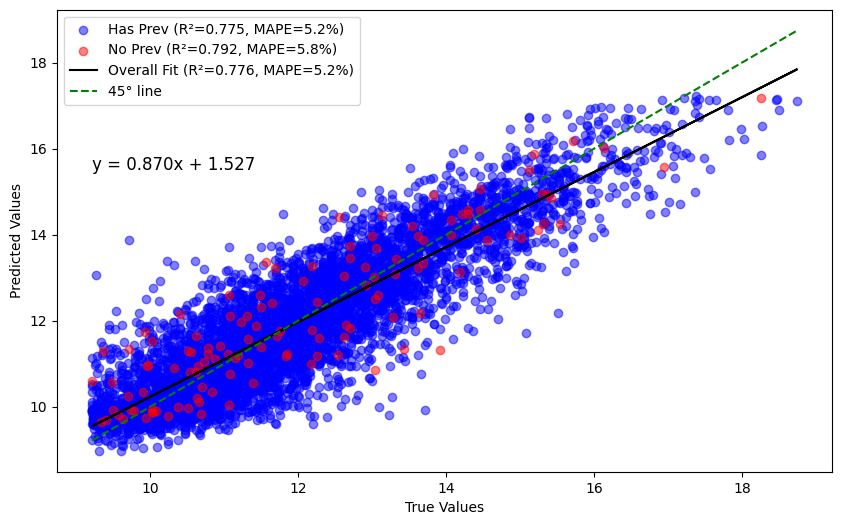

In [ ]:
set_seed(1)
# Mount Google Drive
drive.mount('/content/drive')
# Define source and destination paths
source_path = "/content/drive/My Drive/Colab Notebooks/visual_model.ipynb"
destination_path = "/content/drive/My Drive/visual_model.ipynb"

# Check if the source file exists before moving
if os.path.exists(source_path):
# Move the file
  shutil.move(source_path, destination_path)
  print(f"Notebook moved to: {destination_path}")
artist_data_path= "/content/drive/My Drive/artist_graph_data.xlsx"
artwork_numeric_data = pd.read_excel(artist_data_path)

# image data
zip_path = "/content/drive/My Drive/pic.zip"
extract_path = "/content/data"
load_image_data(zip_path, extract_path)

# Check for missing images
base_dir = "/content/data"
image_paths = artwork_numeric_data['image_url'].values
missing_images = check_image_existence(image_paths, base_dir)
data_filtered = filter_data_for_missing_images(artwork_numeric_data, missing_images, base_dir)
# check functioning of image data after filtering
print(f"After filtering:{check_image_existence(data_filtered['image_url'],base_dir)} ")

# variables to select from df
selected_vars =  ['category','image_url', 'artist', 'transaction_price', 'height',
                  'width', 'medium', 'transaction_house',
                    'transaction_year','transaction_date',
                    'location', 'prev_transaction_price', 'has_prev_price', 'aspect_ratio']
# categorical variables for one-hot encoding
one_hot_vars = ['category', 'artist', 'medium', 'transaction_house', 'location']

# variables that need min-max scaling
numerical_cols = ['height', 'width', 'transaction_year', 'aspect_ratio','prev_transaction_price']


X_train, X_test, y_train, y_test = data_split(data_filtered,
                                                   selected_vars,
                                                   one_hot_vars,numerical_cols,
                                                 2022)
train_loader, test_loader = create_dataloaders(X_train, X_test, pd.DataFrame(y_train),
                                                 pd.DataFrame(y_test),
                                                 transform = resnet_transform(),
                                                 batch_size = 64)

model = CombinedModel(X_train.shape[1]-1, projection_output_dim=100, image_output_dim = 10,
                        model_type = "resnet", fine_tune = True)

# Train the model
CombinedModel, prediction_combined_model, target = train(model, train_loader,
                                                           test_loader,
                                                           epochs = 30)

print(f"Total test batches: {len(test_loader)}")
print(f"Total test samples: {len(y_test)}")
print(f"Test data shape : {X_test.shape}")
print(f"Train data shape : {X_train.shape}")
print("Std of y_test:", np.std(y_test))

fit_visualization(X_test, target, prediction_combined_model, save_path = "combined_resnet.png")


# save just the state_dict
torch.save(CombinedModel.state_dict(), 'combined_model_resnet_state_dict.pth')


In [ ]:
# Grid search parameters
set_seed(1)
projection_dims = [50, 100]
lr_rates = [0.0001]
epochs = [30]
batch_size = [64, 128]
fine_tuning = [True, False]

results = []


for projection_dim, lr, epochs, batch_size, fine_tune in itertools.product(projection_dims, lr_rates, epochs, batch_size, fine_tuning):
    print(f"\n Running: batch_size = {batch_size}, projection_dim={projection_dim}, rate = {lr}, epochs = {epochs}, fine_tine = {fine_tune}")

    # 1. Data split
    X_train, X_test, y_train, y_test = data_split(data_filtered,
                                                 selected_vars,
                                                one_hot_vars,
                                                numerical_cols,
                                               2022)

    # 2. Create dataloaders
    trainloader, testloader = create_dataloaders(X_train, X_test, y_train, y_test, transform = resnet_transform(), batch_size=batch_size)

    # 3. Define model
    in_features = X_train.shape[1]-1 # subtract one dimension for image url column
    odel = CombinedModel(in_features, projection_output_dim=projection_dim,
                        image_output_dim = 10,model_type = "resnet", fine_tune = fine_tune)

    # 4. Train model
    trained_model, predictions, targets = train(
        model,
        trainloader,
        testloader,
        epochs=epochs,
        eta= lr
    )

    # 5. Evaluate final test loss
    predictions = np.array(predictions)
    targets = np.array(targets)
    test_mse = np.mean((predictions - targets) ** 2)

    results.append({
        'batch_size': batch_size,
        'epochs': epochs,
        'projection_dim': projection_dim,
        'learning_rate': lr,
        'fine_tune': fine_tune,
        'test_loss': test_mse
    })

    print(f" Finished: Test MSE = {test_mse:.4f}")

# Sort and show best configs
results = sorted(results, key=lambda x: x['test_loss'])
print("\n Top Grid Search Results:")
for r in results[:5]:
    print(r)


## 4. ViT-small grid search and model training

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dateien entpackt in: /content/data
number of nans: 1201
missing images: 86
number of nans: 0
missing images: 0
After filtering:[] 
Epoch [1/30] Train loss: 113.045625 Test loss: 100.780778
Epoch [2/30] Train loss: 76.020176 Test loss: 58.828847
Epoch [3/30] Train loss: 41.318875 Test loss: 25.897838
Epoch [4/30] Train loss: 16.014866 Test loss: 8.524675
Epoch [5/30] Train loss: 4.428171 Test loss: 2.070577
Epoch [6/30] Train loss: 1.375468 Test loss: 0.897943
Epoch [7/30] Train loss: 1.036505 Test loss: 0.843888
Epoch [8/30] Train loss: 0.919841 Test loss: 0.784045
Epoch [9/30] Train loss: 0.881346 Test loss: 0.895323
Epoch [10/30] Train loss: 0.854798 Test loss: 0.715132
Epoch [11/30] Train loss: 0.803336 Test loss: 0.795498
Epoch [12/30] Train loss: 0.792091 Test loss: 0.730972
Epoch [13/30] Train loss: 0.745216 Test loss: 0.670927
Epoch [14/30] Train loss:

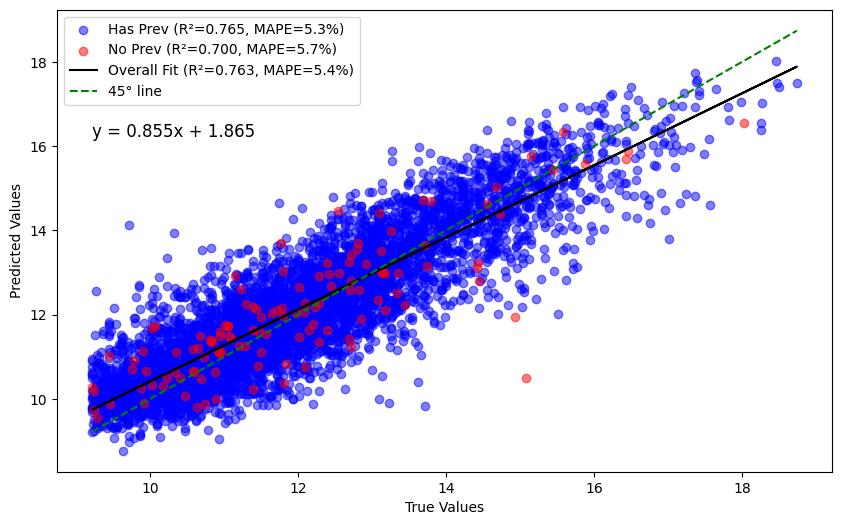

In [ ]:
set_seed(1)
# Mount Google Drive
drive.mount('/content/drive')
# Define source and destination paths
source_path = "/content/drive/My Drive/Colab Notebooks/visual_model.ipynb"
destination_path = "/content/drive/My Drive/visual_model.ipynb"

# Check if the source file exists before moving
if os.path.exists(source_path):
  # Move the file
  shutil.move(source_path, destination_path)
  print(f"Notebook moved to: {destination_path}")


artist_data_path= "/content/drive/My Drive/artist_graph_data.xlsx"
artwork_numeric_data = pd.read_excel(artist_data_path)

# image data
zip_path = "/content/drive/My Drive/pic.zip"
extract_path = "/content/data"
load_image_data(zip_path, extract_path)

# Check for missing images
base_dir = "/content/data"
image_paths = artwork_numeric_data['image_url'].values
missing_images = check_image_existence(image_paths, base_dir)
data_filtered = filter_data_for_missing_images(artwork_numeric_data, missing_images, base_dir)
# check functioning of image data after filtering
print(f"After filtering:{check_image_existence(data_filtered['image_url'],base_dir)} ")

# variables to select from df
selected_vars =  ['category','image_url', 'artist', 'transaction_price', 'height',
                  'width', 'medium', 'transaction_house',
                    'transaction_year','transaction_date',
                    'location', 'prev_transaction_price', 'has_prev_price', 'aspect_ratio']
# categorical variables for one-hot encoding
one_hot_vars = ['category', 'artist', 'medium', 'transaction_house', 'location']

# variables that need min-max scaling
numerical_cols = ['height', 'width', 'transaction_year', 'aspect_ratio','prev_transaction_price']


X_train, X_test, y_train, y_test = data_split(data_filtered,
                                                   selected_vars,
                                                   one_hot_vars,numerical_cols,
                                                 2022)

train_loader, test_loader = create_dataloaders(X_train, X_test, pd.DataFrame(y_train),
                                                 pd.DataFrame(y_test),
                                                 transform = vit_transform(),
                                                 batch_size = 64)


model_vit = CombinedModel(X_train.shape[1]-1, projection_output_dim=100,
                        image_output_dim = 10,model_type = "vit", fine_tune = True)

# Train the model
trained_vit_model, prediction_combined_model, target = train(model_vit, train_loader,
                                                           test_loader,
                                                           epochs = 30)

print(f"Total test batches: {len(test_loader)}")
print(f"Total test samples: {len(y_test)}")
print(f"Test data shape : {X_test.shape}")
print(f"Train data shape : {X_train.shape}")
print("Std of y_test:", np.std(y_test))

fit_visualization(X_test, target, prediction_combined_model,save_path = "combined_vit.png")
# OR, save just the state_dict (recommended)
torch.save(trained_vit_model.state_dict(), 'combined_model_vit_state_dict.pth')



In [ ]:
# Grid search parameters
set_seed(1)
projection_dims = [50, 100]
lr_rates = [0.0001]
epochs = [30]
batch_size = [64, 128]
fine_tuning = [True, False]

results = []


for projection_dim, lr, epochs, batch_size, fine_tune in itertools.product(projection_dims, lr_rates, epochs, batch_size, fine_tuning):
    print(f"\n Running: batch_size = {batch_size}, projection_dim={projection_dim}, rate = {lr}, epochs = {epochs}, fine_tine = {fine_tune}")

    # 1. Data split
    X_train, X_test, y_train, y_test = data_split(data_filtered,
                                                 selected_vars,
                                                one_hot_vars,
                                                numerical_cols,
                                               2022)

    # 2. Create dataloaders
    trainloader, testloader = create_dataloaders(X_train, X_test, y_train, y_test, transform = vit_transform(),batch_size=batch_size)

    # 3. Define model
    in_features = X_train.shape[1]-1 # subtract one dimension for image url column
    model = CombinedModel(in_features, projection_output_dim=projection_dim,
                        image_output_dim = 10,model_type = "vit", fine_tune = fine_tune)

    # 4. Train model
    trained_model, predictions, targets = train(
        model,
        trainloader,
        testloader,
        epochs=epochs,
        eta= lr
    )

    # 5. Evaluate final test loss
    predictions = np.array(predictions)
    targets = np.array(targets)
    test_mse = np.mean((predictions - targets) ** 2)

    results.append({
        'batch_size': batch_size,
        'epochs': epochs,
        'projection_dim': projection_dim,
        'learning_rate': lr,
        'fine_tune': fine_tune,
        'test_loss': test_mse
    })

    print(f" Finished: Test MSE = {test_mse:.4f}")

# Sort and show best configs
results = sorted(results, key=lambda x: x['test_loss'])
print("\n Top Grid Search Results:")
for r in results[:5]:
    print(r)


## 5. Image dimension variations

In [ ]:
# image output dimension variations

if __name__ == '__main__':

    set_seed(1)
    # Mount and load data
    drive.mount('/content/drive')
    source_path = "/content/drive/My Drive/Colab Notebooks/visual_model.ipynb"
    destination_path = "/content/drive/My Drive/visual_model.ipynb"
    if os.path.exists(source_path):
        shutil.move(source_path, destination_path)
        print(f"Notebook moved to: {destination_path}")

    artist_data_path = "/content/drive/My Drive/artist_graph_data.xlsx"
    artwork_numeric_data = pd.read_excel(artist_data_path)

    # Load and filter images
    zip_path = "/content/drive/My Drive/pic.zip"
    extract_path = "/content/data"
    load_image_data(zip_path, extract_path)
    base_dir = "/content/data"
    image_paths = artwork_numeric_data['image_url'].values
    missing_images = check_image_existence(image_paths, base_dir)
    data_filtered = filter_data_for_missing_images(artwork_numeric_data, missing_images, base_dir)
    print(f"After filtering: {check_image_existence(data_filtered['image_url'], base_dir)}")

    # variables to select from df
    selected_vars =  ['category','image_url', 'artist', 'transaction_price', 'height',
                   'width', 'medium', 'transaction_house',
                    'transaction_year','transaction_date',
                    'location', 'prev_transaction_price', 'has_prev_price', 'aspect_ratio']
    # categorical variables for one-hot encoding
    one_hot_vars = ['category', 'artist', 'medium', 'transaction_house', 'location']

    # variables that need min-max scaling
    numerical_cols = ['height', 'width', 'transaction_year', 'aspect_ratio','prev_transaction_price']

    # Split data
    X_train, X_test, y_train, y_test = data_split(data_filtered, selected_vars, one_hot_vars, numerical_cols, 2022)



    # Loop over input dims
    for image_output_dim in [10, 20, 50, 100, 200]:
        print(f"\n Training model with image_output_dim = {image_output_dim}")

        # DataLoaders with image transform
        train_loader, test_loader = create_dataloaders(
            X_train, X_test,
            pd.DataFrame(y_train), pd.DataFrame(y_test),
            transform=resnet_transform(),
            batch_size=64
        )

        # Define and train model
        model = CombinedModel(
            X_train.shape[1] - 1,
            projection_output_dim=100,
            image_output_dim=image_output_dim,
            model_type="resnet",
            fine_tune=True
        )

        model_trained, predictions, targets = train(
            model, train_loader, test_loader, epochs=30
        )

        # Save visualization
        plot_name = f"combined_resnet_image_dim{image_output_dim}.png"
        fit_visualization(X_test, targets, predictions, save_path=plot_name)
